# Introduction to Deep Learning with PyTorch

In this notebook, we will go over the basics of Deep Learning using Pytorch. Pytorch is a framework which allows manipulations of tensors using constructs similar to numpy. In addition it has modules to allow auto differentiation to carryout back-propagation which forms the backbone of training a neural network

## What are Neural Networks

Deep learning is based on Artificial Neural networks which are made up of neurons. A neuron takes inputs, calculates the weighted sum and then passes the sum through some kind of non-linear function (called activation function) as shown below:

![Neuron](./images/neuron.png "Neuron")

<br/>
<br/>

We stack these neurons to make a neural network as shown below:
![Neuron](./images/nn.svg "Neuron")

Let us now create a neural network in PyTorch. We will use this network to train a model to take MNIST data as input and produce the class it belongs to.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

%matplotlib inline

### MNIST 

MNIST dataset has images 28x28 pixels  = 784 pixels. 

We will have 10 units at the output layer to signify the digit (0-9) the image belongs to.

Let us first load the data and print some images

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(0.5, 0.5),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

In [3]:
# let us load a batch of training data and checkout its shape
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [4]:
images.size()

torch.Size([128, 1, 28, 28])

image size of `(32,1,28,28)` means that we have 32 images, with each image of size (1x28x28) (channels x height x width)

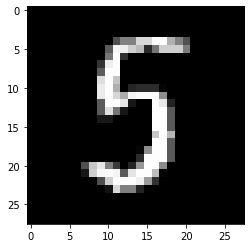

In [5]:
# Let us plot one image
plt.imshow(images[10].numpy().squeeze(), cmap='Greys_r')

### Build Network

In [6]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 192)
        self.fc2 = nn.Linear(192, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
    
    def predict(self, x):
        ''' To predict classes by calculating the softmax '''
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

model = NN()
model

NN(
  (fc1): Linear(in_features=784, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

### Forward pass and Calculate Cross Entropy Loss

In [7]:
# function to view the probability of classification of digit
def view_classification(img, probs):
    probs = probs.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,7), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10).astype(int), size='large');
    ax2.set_title('Probability')
    ax2.set_xlim(0, 1.1)
    

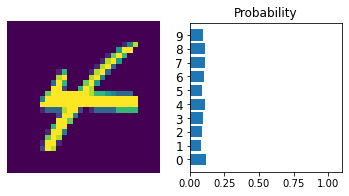

In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images.resize_(128, 784)

# Forward pass through the network
img_idx = 0
logits = model.forward(images)

# Predict the class from the network output
prediction = F.softmax(logits, dim=1)

img = images[0].data
view_classification(img.reshape(1, 28, 28), prediction[0])

In [9]:
trainloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

### Back Propagation
We need to now train the network to adjust its weights by first calculating Cross Entropy Loss and then back propagating the error to adjust weights

In [9]:
# Create an optimizer to train the network by carrying out back propagation
model = NN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [10]:
# Train network

epochs = 1
steps = 0
running_loss = 0
eval_freq = 10
for e in range(epochs):
    for images, labels in iter(trainloader):
        steps += 1
        images.resize_(images.size()[0], 784)

        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % eval_freq == 0:
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(testloader):
                
                images = images.resize_(images.size()[0], 784)                
                predicted = model.predict(images).data
                equality = (labels == predicted.max(1)[1])
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/eval_freq),
                  "Test accuracy: {:.4f}".format(accuracy/(ii+1)))
            running_loss = 0

Epoch: 1/1 Loss: 2.0406 Test accuracy: 0.5407
Epoch: 1/1 Loss: 1.3468 Test accuracy: 0.6823
Epoch: 1/1 Loss: 0.8910 Test accuracy: 0.7483
Epoch: 1/1 Loss: 0.7174 Test accuracy: 0.8199
Epoch: 1/1 Loss: 0.5849 Test accuracy: 0.8447
Epoch: 1/1 Loss: 0.4994 Test accuracy: 0.8663
Epoch: 1/1 Loss: 0.4296 Test accuracy: 0.8682
Epoch: 1/1 Loss: 0.4548 Test accuracy: 0.8636
Epoch: 1/1 Loss: 0.4076 Test accuracy: 0.8898
Epoch: 1/1 Loss: 0.3213 Test accuracy: 0.8802
Epoch: 1/1 Loss: 0.4445 Test accuracy: 0.8952
Epoch: 1/1 Loss: 0.3564 Test accuracy: 0.8916
Epoch: 1/1 Loss: 0.4196 Test accuracy: 0.9016
Epoch: 1/1 Loss: 0.3701 Test accuracy: 0.8919
Epoch: 1/1 Loss: 0.3376 Test accuracy: 0.8896
Epoch: 1/1 Loss: 0.3350 Test accuracy: 0.8972
Epoch: 1/1 Loss: 0.3595 Test accuracy: 0.9022
Epoch: 1/1 Loss: 0.3318 Test accuracy: 0.9055
Epoch: 1/1 Loss: 0.3191 Test accuracy: 0.8992
Epoch: 1/1 Loss: 0.3498 Test accuracy: 0.9057
Epoch: 1/1 Loss: 0.3106 Test accuracy: 0.9134
Epoch: 1/1 Loss: 0.3212 Test accur

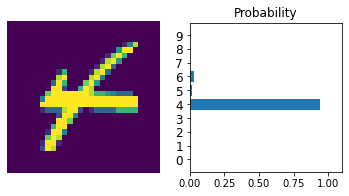

In [11]:

logits = model.forward(img[None,])

# Predict the class from the network output
prediction = F.softmax(logits, dim=1)

view_classification(img.reshape(1, 28, 28), prediction[0])

We can see that model is able to correctly predict the digit after training while before training it predicting all digits with almost equal probability i.e. it was randomly predicting the digit.